# Using FlowCal to reduce number of hyperparameters necessary for FMO-based automatic gating

In [1]:
import os

import numpy as np
import FlowCal
from matplotlib import pyplot as plt # Required for certain FlowCal vizs
from matplotlib.path import Path # Will be used to determine if a point is inside of a polygon (gating)

spleenocytes = os.path.join('test_data', 'Spleenocytes')
fmo_location = os.path.join(spleenocytes, 'Spleenocytes_Tcells_FMO- no CD4 staining_002.fcs')
control_location = os.path.join(spleenocytes, 'Spleenocytes_Tcells_Vaccinated_Saline_004.fcs')


c:\Users\EIYOB\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
fmo = FlowCal.io.FCSData(fmo_location)
control = FlowCal.io.FCSData(control_location)

channel_labels = {fmo.channel_labels()[x]: fmo.channel_labels()[x] for x in range(len(fmo.channels))}
channel_labels

{None: None,
 'CD4': 'CD4',
 'CD8': 'CD8',
 'Live/Dead': 'Live/Dead',
 'CD3': 'CD3',
 'CD45': 'CD45'}

### Flowcal FCSData objects are just numpy arrays with a few extra methods

In [3]:
control

FCSData([[ 9.7874773e+04,  9.8215688e+04,  2.0533861e+05, ...,
           5.6371667e+02,  6.2011816e+03,  2.2884722e+00],
         [ 8.2386781e+04,  8.3805078e+04,  2.0679381e+05, ...,
           4.7229897e+01,  3.0987971e+03,  2.2930002e+00],
         [ 4.3809727e+04,  4.6620242e+04,  1.5768397e+05, ...,
          -3.6585625e+01,  2.9824018e+01,  2.3046641e+00],
         ...,
         [ 6.6251438e+04,  6.7516531e+04,  2.1356136e+05, ...,
           5.1842072e+02,  6.1765557e+03,  9.2000598e+02],
         [ 5.1004402e+04,  5.1375688e+04,  2.1606417e+05, ...,
           2.0405069e+02,  1.3003390e+03,  9.2002441e+02],
         [ 1.5855777e+05,  1.2784651e+05,  2.5429009e+05, ...,
           2.4444417e+03,  2.5555611e+04,  9.2006738e+02]], dtype=float32)

### and you can index by channel names!

In [4]:
control.channels

('FSC-A',
 'FSC-H',
 'FSC-W',
 'SSC-A',
 'SSC-H',
 'SSC-W',
 'BV421-A',
 'BV510-A',
 'BV605-A',
 'BV650-A',
 'BV786-A',
 'BB515-A',
 'PE-A',
 'PE-CF594-A',
 'PerCP-Cy5-5-A',
 'APC-A',
 'APC-R700-A',
 'APC-Cy7-A',
 'Time')

In [5]:
control[:,['SSC-A']]

FCSData([[ 81894.46 ],
         [ 41879.383],
         [ 56094.55 ],
         ...,
         [ 40039.758],
         [ 60550.605],
         [159780.66 ]], dtype=float32)

### FlowCal can gate blindly based solely on point density.  We can use this to autogate gating based on FMOs

In [6]:
# First lets see how the channels are labeled

channel_labels = {fmo.channels[x]: fmo.channel_labels()[x] for x in range(len(fmo.channels))}
channel_labels

{'FSC-A': None,
 'FSC-H': None,
 'FSC-W': None,
 'SSC-A': None,
 'SSC-H': None,
 'SSC-W': None,
 'BV421-A': None,
 'BV510-A': None,
 'BV605-A': None,
 'BV650-A': None,
 'BV786-A': 'CD4',
 'BB515-A': None,
 'PE-A': 'CD8',
 'PE-CF594-A': None,
 'PerCP-Cy5-5-A': 'Live/Dead',
 'APC-A': 'CD3',
 'APC-R700-A': None,
 'APC-Cy7-A': 'CD45',
 'Time': None}

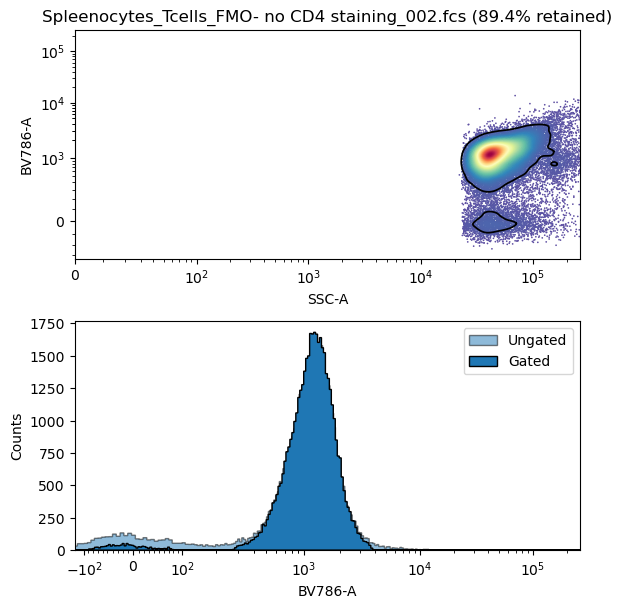

In [7]:
# Seeing from the file title that the FMO has knocked out CD4, 
# and seeing from the channel labels that CD4 corresponds to 'BV786', 
# so lets gate according to that and 'SSC-A' 
# (adding a second dimension can also filter out easy-to-find garbage, and SSC looks at granularity/translucency and is a good arbitrary choice)

negative = FlowCal.gate.density2d(
    fmo,
    channels = ['SSC-A','BV786-A'],
    gate_fraction = .90,
    full_output= True
)

FlowCal.plot.density_and_hist(
    fmo,
    gated_data=negative.gated_data,
    gate_contour=negative.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

### As you can see doing the same gate on the 'control', there is a third population in the control which isn't in the FMO.  We can reasonably deduce that this population is the CD4 cells, as it is completely gone when this stain is not added.

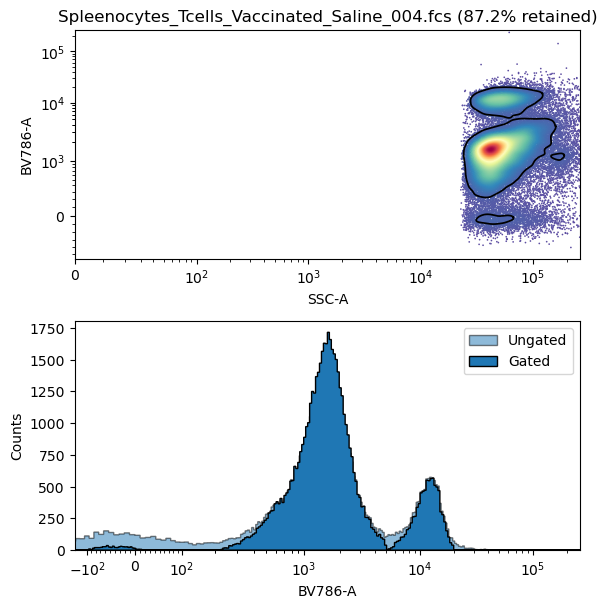

In [8]:
gated_control = FlowCal.gate.density2d(
    control,
    channels = ['SSC-A','BV786-A'],
    gate_fraction = .88,
    full_output= True
)

FlowCal.plot.density_and_hist(
    control,
    gated_data=gated_control.gated_data,
    gate_contour=gated_control.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

### As you can see, the automatic gating algorithm in FlowCal grabs both populations. What is more perplexing is that FlowCal does not offer any native methods to apply the gates generated for one sample to another.

#### We shouldn't ditch FlowCal based off of this, however, because its auto-gating is still elegant and intelligent, and because FlowCal objects are essentially just numpy arrays, we can do this ourselves!

#### One way to accomplish this would be to trim some events from the sample before drawing the gate

In [9]:
# One method of trimming is to simply subtract the gated cells from the FMO sample to the control sample

# Because applying a gate from one sample to another does not exits in FlowCal we need to write our own function
def gate_points(flowcal_object, channels, polygon_vertices):
    """Returns a numpy mask based on whether or not the unnown points are within the polygon defined by given vertices"""
    path = Path(polygon_vertices)
    
    # Select only channels of interest (the two dimensions concerned with this particular gate)
    point_cloud = flowcal_object[:, channels]

    # determine if each point in unknown_array is within the polygon
    in_polygon = path.contains_points(point_cloud)
    return in_polygon

gated_control_mask = gate_points(control,['SSC-A','BV786-A'], negative.contour[0])

# We want to eliminate points in the gate rather than keep points in the gate
trimmed_control = control[~gated_control_mask]

#### Now we can see how the gates are auto-drawn once this sup-population is subtracted out

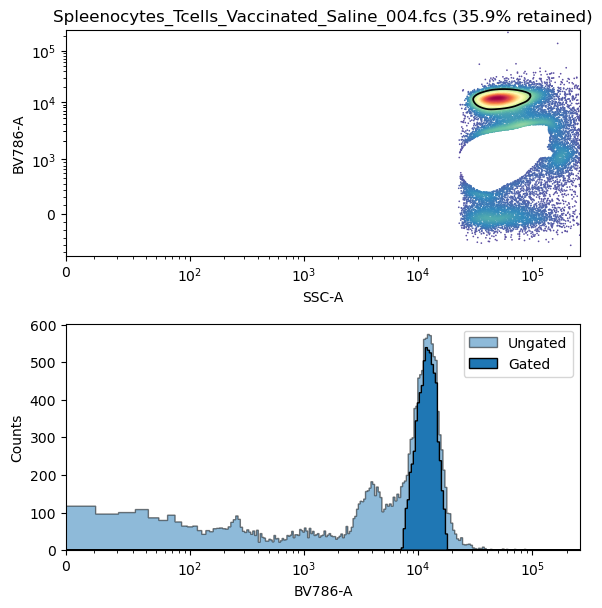

In [10]:
trimmed_gate = FlowCal.gate.density2d(
    trimmed_control,
    channels = ['SSC-A','BV786-A'],
    gate_fraction = .37,
    full_output= True
)

FlowCal.plot.density_and_hist(
    trimmed_control,
    gated_data=trimmed_gate.gated_data,
    gate_contour=trimmed_gate.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

#### This maybe wasn't too impressive.  We had to capture a very small fraction to limit the gated set to our desired population, and it still grabbed another shred of CD4- cells. We could eliminate by taking the contour[0], therefore the largest one, but it is still grabbing an insubstantial portion of our CD4 cells. Below is an easier and more robust method of trimming cells but subtracting a gate is still an import possibility to consider in some cases.

In [11]:
# We can simply find the BV786-A-most edge of the gates found in the FMO and simply subtract all events with flourescence less than this

# Gate Contours may return multiple gates, and we need the highest value of any of them.  
# These are in a tuple, which explains why this is achieved by list comprehension rather than indexing another numpy level
maximum_gated_value = max([np.max(x[:, 1]) for x in negative.contour])

chopped_control = control[control[:, 'BV786-A'] > maximum_gated_value]

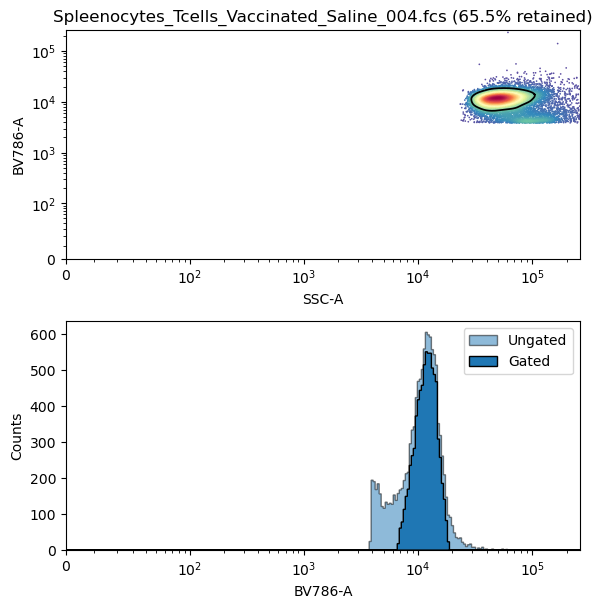

In [12]:
chopped_gate = FlowCal.gate.density2d(
    chopped_control,
    channels = ['SSC-A','BV786-A'],
    gate_fraction = .67,
    full_output= True
)

FlowCal.plot.density_and_hist(
    chopped_control,
    gated_data=chopped_gate.gated_data,
    gate_contour=chopped_gate.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

### Now the gate location seems good, and its shape seems good, but if we try to increase the size of the gate by increasing its fraction we start getting errant populations rather than simply increasing the size of the gate.

### But because everything is essentially just a numpy array we can actually just increase the size of the gate

In [13]:
# First we need a function to blow up a polygon.  
# One certainly already exists in some library or another, but the logic is simple enough that I just made one:

def scale_polygon(vertices, scale_factor):
    # Calculate the centroid
    centroid = np.mean(vertices, axis=0)

    # Translate vertices to the centroid
    translated_vertices = vertices - centroid

    # Scale the translated vertices
    scaled_vertices = translated_vertices * scale_factor

    # Translate back to the original position
    scaled_vertices = scaled_vertices + centroid

    return scaled_vertices


# Now lets scale the polygon (take note that 'contour' is an array of polygons,  so we nee dto unpack and repack it after scaling)

expanded_contour = scale_polygon(chopped_gate.contour[0], 1.2)
expanded_contour = np.array([expanded_contour])

### Lets apply this to the untrimmed control data

In [14]:
gated_control_mask = gate_points(
    control,
    ['SSC-A','BV786-A'],
    expanded_contour[0]
)

gated_control_points = control[gated_control_mask]

np.mean(gated_control_mask) #To quickly get the fraction of gated cells without the slow visualization

0.13195436188019224

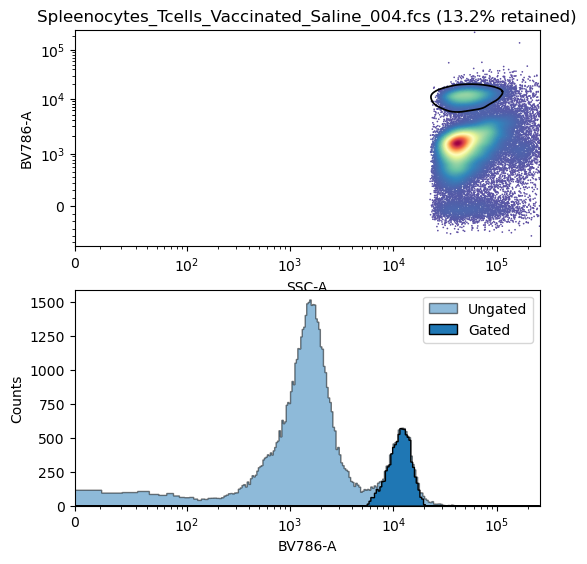

In [15]:
FlowCal.plot.density_and_hist(
    control,
    gated_data=gated_control_points,
    gate_contour=expanded_contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

You can see that the ultimitely gated population has a bit more nuance than simply chopping off a 1D histogram. This is because of the naturally diagonal shape of these populations.  Bigger(FSC-A) or more granular(SSC-A) cells have more potential for reflection or non-specific absorbance in the channel of interest, so a reading might be considered positive for a smaller or more translucent cell that would be considered negative for a larger or more granular cell. This is the purpose of using a 2D gate of the channel of interest against FSC-A or SSC-A.

In [16]:
# We can then apply this extracted gate to new unseen data (which doesn't have a CD4+ population)

unknown_sample_location = fmo_location = os.path.join(spleenocytes, 'Spleenocytes_Tcells_Vaccinated_GK15__3_009.fcs')
unknown_sample =  FlowCal.io.FCSData(unknown_sample_location)

gated_unknown_mask = gate_points(
    unknown_sample,
    ['SSC-A','BV786-A'],
    expanded_contour[0]
)

gated_unknown_points = unknown_sample[gated_unknown_mask]

np.mean(gated_unknown_mask)

0.00031905559543750497

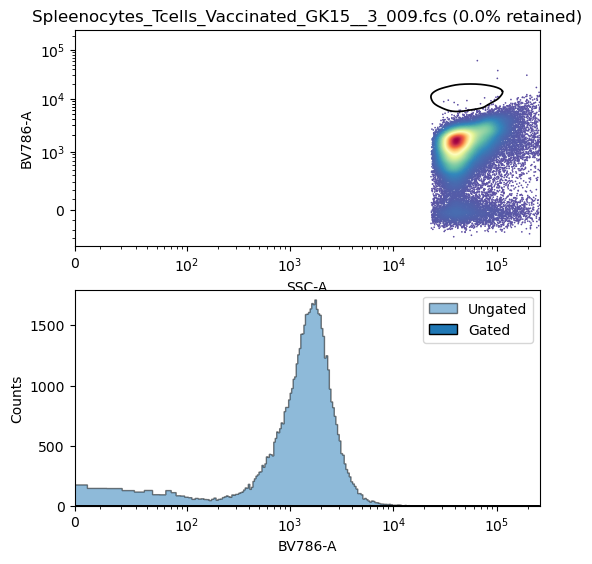

In [17]:
FlowCal.plot.density_and_hist(
    unknown_sample,
    gated_data=gated_unknown_points,
    gate_contour=expanded_contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

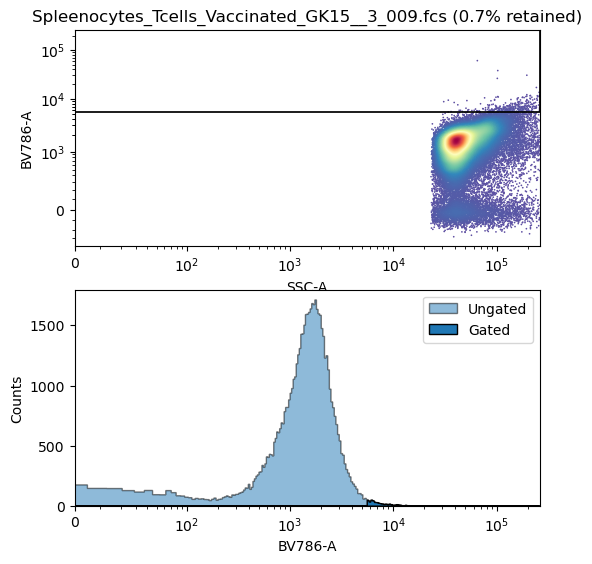

In [18]:
# Comparing this to a square gate emulating a a 1D gate, you can see that more negative cells are gated positive

# Find the minimum gated value for the square gate
minimum_gated_value = min([np.min(x[:, 1]) for x in expanded_contour])

# Craft the polygon
y = minimum_gated_value
square_contour = np.array([[[0,y],[1000000, y],[1000000, 1000000],[0,1000000],[0,y]]])

# Filter according to the square gate
square_gate_mask = gate_points(
    unknown_sample,
    ['SSC-A','BV786-A'],
    square_contour[0]
)

square_gated_data = unknown_sample[square_gate_mask]

FlowCal.plot.density_and_hist(
    unknown_sample,
    gated_data=square_gated_data,
    gate_contour=square_contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

As you can see, because of the diagonal nature of this population, we are grabbing many negative events as positive.  But this brings a larger problem:  You've likely been somewhat underwhelmed by proposed solutions as they all leave a lot of likely positive cells ungated, so can this be solved?  **YES!!**

### Below you will see the first approach with a more aggressive gate

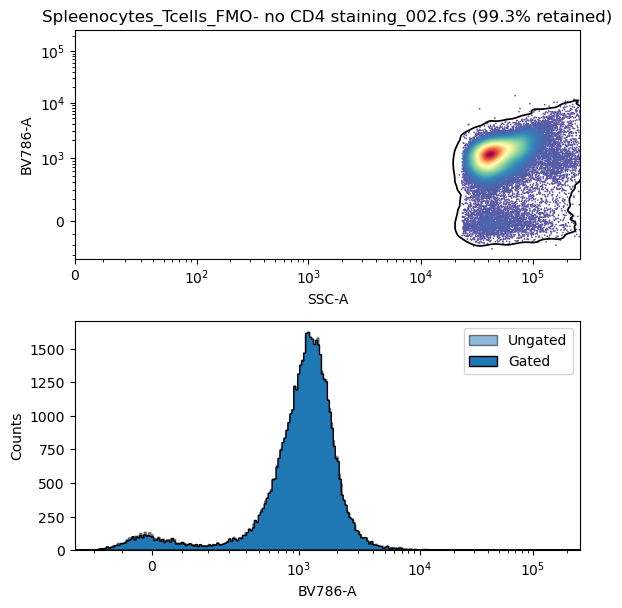

In [19]:
# Rerunning the first autogate with a more aggressive gate_fraction

negative = FlowCal.gate.density2d(
    fmo,
    channels = ['SSC-A','BV786-A'],
    gate_fraction = .999,
    full_output= True
)

FlowCal.plot.density_and_hist(
    fmo,
    gated_data=negative.gated_data,
    gate_contour=negative.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

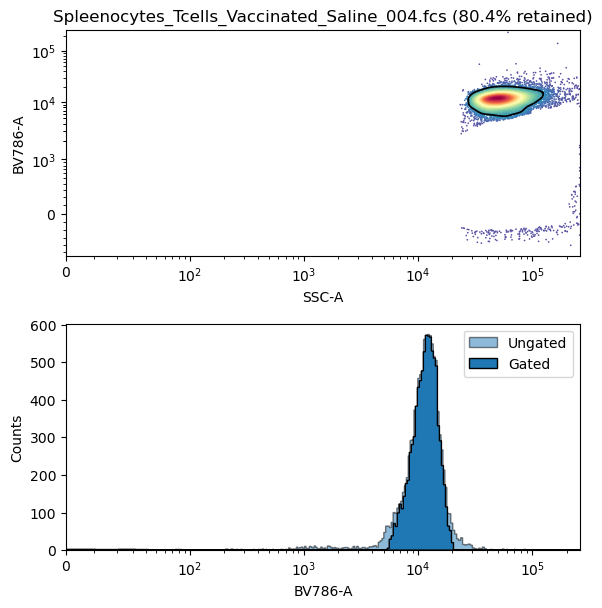

In [20]:
# Now once again we are removing the points from the sample and drawing the gate on the sample with points removed.  
# (Note I was able to draw a more aggresive gate because I was less concerned about grabbing unfiltered noise)

gated_control_mask = gate_points(control,['SSC-A','BV786-A'], negative.contour[0])

aggressive_control = control[~gated_control_mask]

aggressive_gate = FlowCal.gate.density2d(
    aggressive_control,
    channels = ['SSC-A','BV786-A'],
    gate_fraction = .85,
    full_output= True
)

FlowCal.plot.density_and_hist(
    aggressive_control,
    gated_data=aggressive_gate.gated_data,
    gate_contour=aggressive_gate.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

#### So we still arent getting ALL of the positive cells, but we have a much larger gated area and we've done so while respecting the positive relationship between cell granularity and non-specific absorbance.

##### Also, while many of the 20% of remaining cells perhaps should be considered 'postive' there is some nuance here.  Cells at the fuzzy edges of these gates tend to be cells behaving unnaturally due to culture conditions, and while we might be wrong to call them negatice our ultimate goal is to gate quality cells, and these weirdos are likely rightfully excluded from that population

In [21]:
# Lets apply this to our full control and out experimental negative and see how this more-aggressive yet nuanced gate performs

aggressive_gated_control_mask = gate_points(
    control,
    ['SSC-A','BV786-A'],
    aggressive_gate.contour[0]
)

aggressive_gated_control_data = control[aggressive_gated_control_mask]

np.mean(aggressive_gated_control_mask)

0.13309070806652232

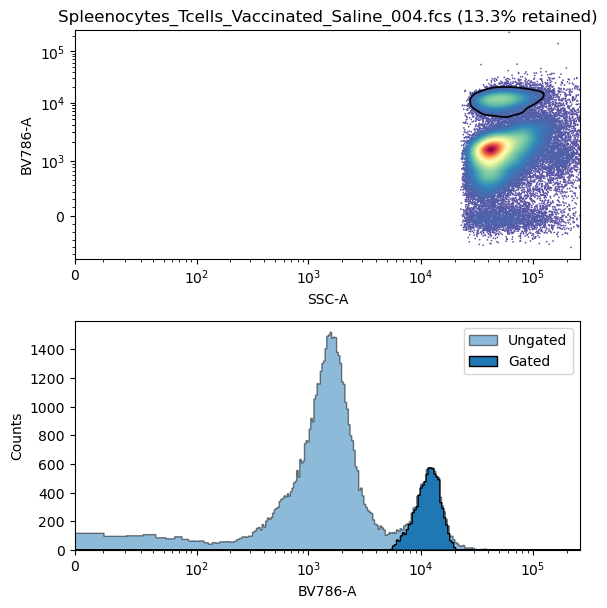

In [22]:
FlowCal.plot.density_and_hist(
    control,
    gated_data=aggressive_gated_control_data,
    gate_contour=aggressive_gate.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

In [23]:
# And also the experimental negative

aggressive_gated_unknown_mask = gate_points(
    unknown_sample,
    ['SSC-A','BV786-A'],
    aggressive_gate.contour[0]
)

aggressive_gated_unknown_data = unknown_sample[aggressive_gated_unknown_mask]

np.mean(aggressive_gated_unknown_mask)

0.00046263061338438225

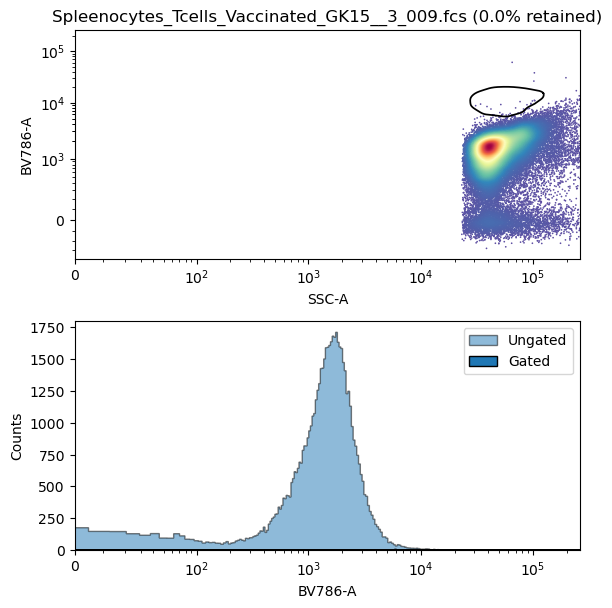

In [24]:
FlowCal.plot.density_and_hist(
    unknown_sample,
    gated_data=aggressive_gated_unknown_data,
    gate_contour=aggressive_gate.contour,
    density_channels= ['SSC-A','BV786-A'],
    hist_channels=['BV786-A'],
    density_params={
        'mode': 'scatter'
    }
)

plt.tight_layout()
plt.show()

As you can see, using 2D gates does infact respect the natural shape of these populations better than a 1D gate.  The simple output of the np.mean() method on the gate mask provides a very performant output on unknown data which can be easily transformed into a pass/fail test with a simple percentage threshold.

## **IN CONCLUSION:**

We've shown how to draw gates on one sample and apply them to another.  We've shown how to utilize FMOs to do this intelligently and automatically, and we've shown some ways to alter the gates before reapplying them.

### **BUT MOST IMPORTANTLY**:  We've shown how to reduce the number of hyperparameters for automatic gating down to a single one: 'gate_fraction'
(potentially also scale_factor if you're happy with the shape of the output gate but would like to decrease Type-II errors at the probable expense of Type-I errors)

----------

## UPDATE:  AutoGator object

#### Here is how we can do aggressive 'subtractive two-step gating' using the AutoGator object

In [25]:
# Creating the object.  This is where hyperparameters are set
from src.autogator import AutoGator

spleen_gator = AutoGator(
    gate_fraction=0.85, # How aggresive the 'positive' gate should be
    negative_gate_fraction=0.999, # How aggressive the 'negative' (subtractive) gate should be
    control_sample= control_location, # Location of the control sample
    second_dimension='SSC-A' # Second axis to use for gating
)

In [26]:
# Add FMO locations (only one for this dataset)

spleen_gator.add_fmo(
    name = 'CD4', # Name of the target for the omitted fluorescent dye
    location = fmo_location,
)


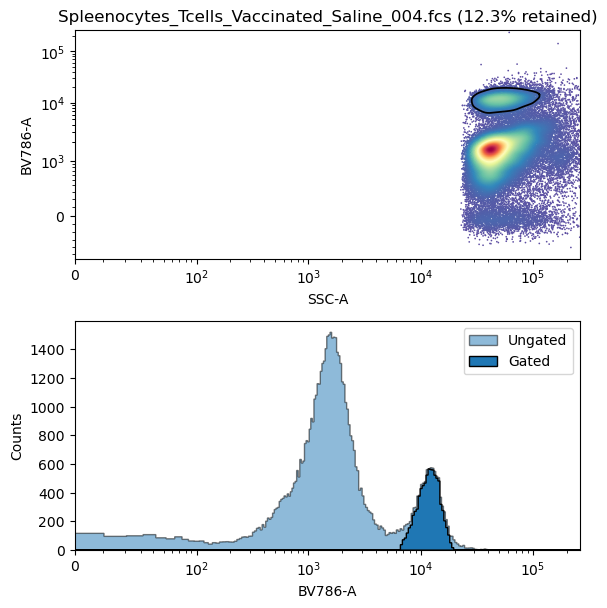

0.12295572856682176


In [27]:
control_mask = spleen_gator.gate(
    control, # Location of the sample to be gated
    'CD4', # Name of the gate
    plot = True # Whether or not visualize the plot, (adds a couple seconds to execution time, and only works in Jupyter Kernel)
)
print(np.mean(control_mask))

In [34]:
# Getting the gate boundry itself

cd4_boundry = spleen_gator.get_gate_boundry(
    target= 'CD4'
)

print(cd4_boundry['channels'])
cd4_boundry['contour'][0].shape

['SSC-A', 'BV786-A']


(500, 2)